# Computing Hillslope Discharge Across Multiple REWs

This notebook outlines how to access parameters and forcing data across a collection of REWs in order to compute hillslope discharge. We pay special attention to dealing with REW parameter groups (which simplify calibration procedures) and REW forcing groups (which simplify hillslope discharge computations). 

In [1]:
%matplotlib inline
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, NonlinearReservoir, NonlinearReservoir, TwoLinearReservoir, TwoParallelLinearReservoir
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import pickle
from datetime import date
import pandas as pd
import numpy as np
import time
import sys

/Users/nathankarst/anaconda/envs/py2k_gis/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, we'll need to set up some data structures to hold REW parameters and forcing data. We'll assume that these have already been computed and have been stored in the `model_data` subfolder of the parent folder.

The `rew_config` dictionary has as its keys the list of all REWs to be modeled in the simulation. The value of each key contains data primarily related to physical topological attributes of each REW. The most important field in this example will be `group`, which specifies which collection of parameters we will be using to configure each REW. See the description of `gorup_params` below for more details.

The `rew_forcing` dictionary contains a number of forcing time series. The only one we will be using here is precipiation, `ppt`. 

The `group_params` dictionary has as its keys the list of all REW parameter groups. For each group, we can specific both scalars like field capacity or maximum evapotranspiration, and classes like specific groundwater and vadose zone mdoels. **The parameters enumerated for each group must include those needed to fully populate the chosen vadose zone and groundwater zone models, and the naming conventions between `group_params` and each class must match.** For instance, if the chosen vadose zone model has a field capacity attribute named `sfc`, then each value in the `group_params` dictionary must have a `sfc` key. Each REW will be instantiated using the parameters corresponding to the its `group` field in `rew_config`. This allows us to perform expensive calibration procedures only a few representative REW "types" (e.g., coastal belt covered in a Douglas fir), rather than on each REW individually. 

The `model_config` dictionary contains the high level parameters needed to spool up and execute the time domain simulation. Values include time stamps at which hillslope discharge will be computed, as well as the time step lengths and resampling frequencies necessary to map forcing data onto the desired simulation timescales. 

In [2]:
# Load config files, forcing file, and paramters for each group
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))

sys.path.append(os.path.join(parent_dir, 'StreamflowTempModel', '1_data_preparation'))
from prep_rew_params import main as pparam 
pparam()

# These dictionaries contain the all the data we'll need to instantiate 
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
rew_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','rew_forcing_dict.p'), "rb" ) )
group_params = pickle.load( open( os.path.join(parent_dir,'model_data','group_params.p'), "rb" ))
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))


Before starting the simulation, it's convenient to load some of the model configuration data into the local workspace, rather than continually pulling from the `model_config` dictionary. 

The most important quantities here are the `start_date`, `stop_date` and `spinup_date`. The first two are self-explanatory; the last specifies the date at which we assume transients related, for instance, to starting with empty groundwater and vadose zone stocks have exited the system. 

Note that `model_config` typically contains datetime indices, time steps, and resampling frequencies related to both the hillslope dischage _and_ channel routing models. Since we'll only be dealing with the hillslope part of the process in this example, we'll simplify the notation. 

In [3]:
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_hillslope']
t = model_config['t_hillslope']
resample_freq_hillslope = model_config['resample_freq_hillslope']
timestamps_hillslope = model_config['timestamps_hillslope']

With the forcing data, REW parameterizations, and overarching model description in hand, we're finally ready to run the model. We assume that in terms of hillslope discharge, no REW depends on any other, and so we can simply simulate discharge sequentially along the list of REWs. For each REW, we

* Instantiate a `REW` instance using the parameterization provided in `group_params`. For each REW, the appropriate group ID is located in `rew_config[REW ID]['group']`;
* Intialize empty vadose zone and groundwater zone stocks, as well as empty time series related to the major fluxes of each zone;
* Populate the attributes of both the vadose and groundwater zones. At REW instantiation, both the vadose zone and groundwater zone are empty. Therefore, the `group_params` dictionary **must** specify all quantities necessary for model execution, and these quantities must have the same variable name in both `group_params` and the corresponding model class; 
* Resample forcing data at the hillslope discharge simulation timescale specified in `model_config`;
* Simulate hillslope discharge at each time specified in the `t_hillsope` field of `model_config`;
* Store the flux and stock time series data in a Pandas data frame for each REW, and bundle these Pandas data frames into a dictionary of solved hillslopes indexed by its group ID;
* Save these solved hillslopes to the pickle file `solved_group_hillslopes` in the `model_data folder`.

In [4]:
solved_group_hillslopes_dict = {}
for group_id in group_params.keys():
    rew_id = rew_config.loc[rew_config.group==group_id].index[0]
    rew = REW(group_params[group_id]['vz'], group_params[group_id]['gz'],  **{'pet':rew_forcing[rew_id].pet, 'ppt':rew_forcing[rew_id].ppt, 'aspect':90})

    storage    = np.zeros(np.size(t))
    groundwater     = np.zeros(np.size(t))
    discharge       = np.zeros(np.size(t))
    leakage         = np.zeros(np.size(t))
    ET              = np.zeros(np.size(t))

    # Parameterize vz and gz
    for param in [x for x in rew.vz.__dict__.keys() if (x!='rew')]:
        setattr(rew.vz, param, group_params[group_id][param])
    for param in [x for x in rew.gz.__dict__.keys() if (x!='rew')]:
        setattr(rew.gz, param, group_params[group_id][param])

    # Resample pet and ppt to integration timestep
    ppt = np.array(rew.ppt[start_date:stop_date].resample(resample_freq_hillslope).ffill())
    pet = np.array(rew.pet[start_date:stop_date].resample(resample_freq_hillslope).ffill())

    # Solve REW hillslope
    for i in range(len(t)):
        rew.vz.update(dt,**{'ppt':ppt[i],'pet':pet[i]})
        storage[i] = rew.vz.storage
        leakage[i]      = rew.vz.leakage
        ET[i]           = rew.vz.ET   
        rew.gz.update(dt,**{'leakage':leakage[i]})
        groundwater[i] = rew.gz.groundwater
        discharge[i] = rew.gz.discharge

    # Save all results as daily data. 
    solved_hillslope = pd.DataFrame({'storage':storage, 'leakage':leakage, 'ET':ET, 'groundwater':groundwater, 'discharge':discharge}, index=timestamps_hillslope)
    solved_group_hillslopes_dict[group_id] = solved_hillslope.resample('D').mean()

pickle.dump( solved_group_hillslopes_dict, open( os.path.join(parent_dir,'model_data','solved_group_hillslopes_dict.p'), "wb" ) )

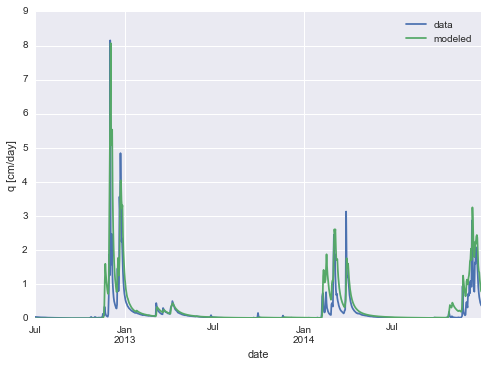

In [5]:
discharge = np.array(solved_group_hillslopes_dict[0].discharge)
sns.set_style('dark')
elder_df = pickle.load( open( os.path.join(parent_dir, 'calibration_data', 'elder_2010_2015.p'), 'rb'))

outflows_df = pd.DataFrame({ 'data':np.array(elder_df['runoff'][start_date:stop_date]),'modeled':discharge}, index = elder_df[start_date:stop_date].index)
ax = outflows_df.plot()
fig = ax.get_figure()
fig.axes[0].set_ylabel('q [cm/day]')
ax.grid(True)
plt.show()